In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

%matplotlib inline
%config InlineBackend.figure_format='retina'

import torch.nn.functional as F
from torchvision.datasets.utils import download_url
device = ("cuda" if torch.cuda.is_available() else "cpu")

from google.colab import files

In [51]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE =\
["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [52]:
uploaded = files.upload()

Saving airbnb_raw.csv to airbnb_raw (1).csv


In [109]:
data = pd.read_csv("airbnb_raw.csv")

In [110]:
def clean(df):
    df["Room type"] = df["Descriptions"].str.split(" in", expand=True)[0]
    df.loc[:, "Guests"] = df["Info"].str.rsplit('guest', 1).str.get(0)
    df.loc[:, "Bedrooms"] = df["Info"].str.split(" · ", n = 0, expand = True)[1].str.rsplit('bedroom', 1).str.get(0)
    df.loc[:, "Beds"] = df.loc[:, "Info"].str.split(" . ", n = 0, expand = True)[2].str.rsplit('bed', 1).str.get(0)
    df.loc[:, "Bathrooms"] = df.loc[:, "Info"].str.split(" . ", n = 0, expand = True)[3]
    df.loc[:,"Price"] = df.loc[:, "Prices"].str.split("$", n = 0, expand = True)[1].str.replace(" / night", "")
    df.loc[:,"Bathrooms"] = df["Bathrooms"].str.rsplit('shared', 1).str.get(0)
    df.loc[:,"Bathrooms"] = df["Bathrooms"].str.rsplit('bath', 1).str.get(0)
    df.loc[:,"Ratings"] = df.loc[:, "Ratings"].str.split(" ", n = 0, expand = True)[1].str.replace(" out of 5;", "")
    df.loc[:, "Reviews"] = df["Review number"].str.rsplit('reviews', 1).str.get(0)
    return df

In [111]:
def tonumeric(df):
    df.loc[:, "Guests"] = pd.to_numeric(df.Guests, errors = 'coerce')
    df.loc[:, "Beds"] = pd.to_numeric(df.Beds, errors = 'coerce')
    df.loc[:, "Bedrooms"] = pd.to_numeric(df.Bedrooms, errors = 'coerce')
    df.loc[:, "Bathrooms"] = pd.to_numeric(df.Bathrooms, errors = "coerce")
    df.loc[:, "Ratings"] = pd.to_numeric(df.Ratings, errors = 'coerce')
    df.loc[:, "Price"] = pd.to_numeric(df.Price, errors = 'coerce')
    df.loc[:, "Reviews"] = pd.to_numeric(df.Reviews, errors = 'coerce')    
    return df

In [112]:
df = clean(data)

In [113]:
df2 = tonumeric(df)

In [114]:
airbnb_data = df2.drop(["Unnamed: 0", "Prices", "Info", "Review number"], axis = 1)
airbnb_data = airbnb_data.dropna()

In [115]:
airbnb_data['Room type'].unique()

array(['Entire house', 'Private room', 'Hotel room', 'Entire apartment',
       'Shared room', 'Entire loft', 'Entire condominium',
       'Entire guest suite', 'Entire townhouse', 'Entire guesthouse',
       'Treehouse', 'Entire cottage', 'Tiny house', 'Camper/RV', 'Beds',
       'Boat', 'Room'], dtype=object)

In [116]:
a=['Hotel room', 'Camper/RV', 'Beds','Boat', 'Room', 'Treehouse']
airbnb_data = airbnb_data[~airbnb_data['Room type'].isin(a)]

In [117]:
airbnb_data.describe()

,Ratings,Guests,Bedrooms,Beds,Bathrooms,Price,Reviews
count,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000,662.000000
mean,4.763489,2.688822,1.172205,1.480363,1.283233,79.507553,108.309668
std,0.269919,1.650149,0.464094,1.091325,0.786270,65.688250,122.365042
min,2.830000,1.000000,1.000000,0.000000,1.000000,15.000000,3.000000
25%,4.700000,2.000000,1.000000,1.000000,1.000000,39.000000,17.000000
50%,4.840000,2.000000,1.000000,1.000000,1.000000,61.000000,62.500000
75%,4.930000,4.000000,1.000000,2.000000,1.000000,99.000000,159.000000
max,5.000000,10.000000,4.000000,12.000000,10.000000,741.000000,667.000000


In [118]:
airbnb = airbnb_data[airbnb_data['Price'] <= 600]

In [119]:
airbnb.describe()

,Ratings,Guests,Bedrooms,Beds,Bathrooms,Price,Reviews
count,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000,661.000000
mean,4.763903,2.677761,1.167927,1.473525,1.275340,78.506808,108.369138
std,0.269913,1.626654,0.451194,1.077867,0.760171,60.477209,122.448133
min,2.830000,1.000000,1.000000,0.000000,1.000000,15.000000,3.000000
25%,4.700000,2.000000,1.000000,1.000000,1.000000,39.000000,17.000000
50%,4.840000,2.000000,1.000000,1.000000,1.000000,61.000000,62.000000
75%,4.930000,4.000000,1.000000,2.000000,1.000000,99.000000,159.000000
max,5.000000,10.000000,4.000000,12.000000,10.000000,500.000000,667.000000


In [120]:
def label_accommodation(df):
  if df['Room type'] == 'Entire house':
    return 'Entire home/apt'
  if df['Room type'] == 'Entire apartment':
    return 'Entire home/apt'
  if df['Room type'] == 'Entire loft':
    return 'Entire home/apt'

  if df['Room type'] == 'Entire condominium':
    return 'Entire home/apt'
  if df['Room type'] == 'Entire guest suite':
    return 'Entire home/apt'
  if df['Room type'] == 'Entire townhouse':
    return 'Entire home/apt'

  if df['Room type'] == 'Entire guesthouse':
    return 'Entire home/apt'
  if df['Room type'] == 'Entire cottage':
    return 'Entire home/apt'
  if df['Room type'] == 'Tiny house':
    return 'Entire home/apt'

  if df['Room type'] == 'Private room':
    return 'Private room'
  if df['Room type'] == 'Shared room':
    return 'Shared room'

In [121]:
airbnb['Accommodation type'] = airbnb.apply (lambda df: label_accommodation(df), axis=1)

In [122]:
airbnb['City'].replace({'New York': 1, 'Los Angeles': 2, 'San Francisco': 3, 'Boston': 4, 'Chicago': 5}, inplace = True)
airbnb['Accommodation type'].replace({'Entire home/apt': 0, 'Private room': 1, 'Shared room': 2}, inplace = True)

In [123]:
airbnb.loc[:, "City"] = pd.to_numeric(airbnb.City, errors = 'coerce')
airbnb.loc[:, "Accommodation type"] = pd.to_numeric(airbnb['Accommodation type'], errors = 'coerce')

In [124]:
airbnb.head()

,Names,Descriptions,Facilities,Ratings,Links,City,Room type,Guests,Bedrooms,Beds,Bathrooms,Price,Reviews,Accommodation type
2,Flatbush Hideaway - Quiet and close to subway!...,Entire house in Flatbush,Wifi·Selfcheck-in·Airconditioning·Kitchen,4.85,http://airbnb.com/rooms/31221559?previous_page...,1,Entire house,4,1.0,3.0,1.0,39.0,86.0,0
3,"Friendly, unpretentious, close to the subway -...",Private room in Park Slope,Wifi·Airconditioning·Kitchen,4.91,http://airbnb.com/rooms/23839200?previous_page...,1,Private room,2,1.0,1.0,1.0,39.0,80.0,1
7,Soho Private Clean & Quiet Bedroom - null - Ne...,Private room in Soho,Wifi·Kitchen,4.80,http://airbnb.com/rooms/35680818?previous_page...,1,Private room,1,1.0,1.0,1.0,39.0,10.0,1
10,"Gold Room in Old American Style House, Near Su...",Private room in Queens,Wifi·Indoorfireplace·Selfcheck-in·Airconditioning,5.00,http://airbnb.com/rooms/41986091?previous_page...,1,Private room,2,1.0,1.0,1.5,40.0,7.0,1
12,Downtown Bronx Studio 15 min ride to Manhattan...,Entire apartment in Melrose,Wifi·Selfcheck-in·Airconditioning·Kitchen,4.88,http://airbnb.com/rooms/35584546?previous_page...,1,Entire apartment,3,1.0,1.0,1.0,56.0,24.0,0


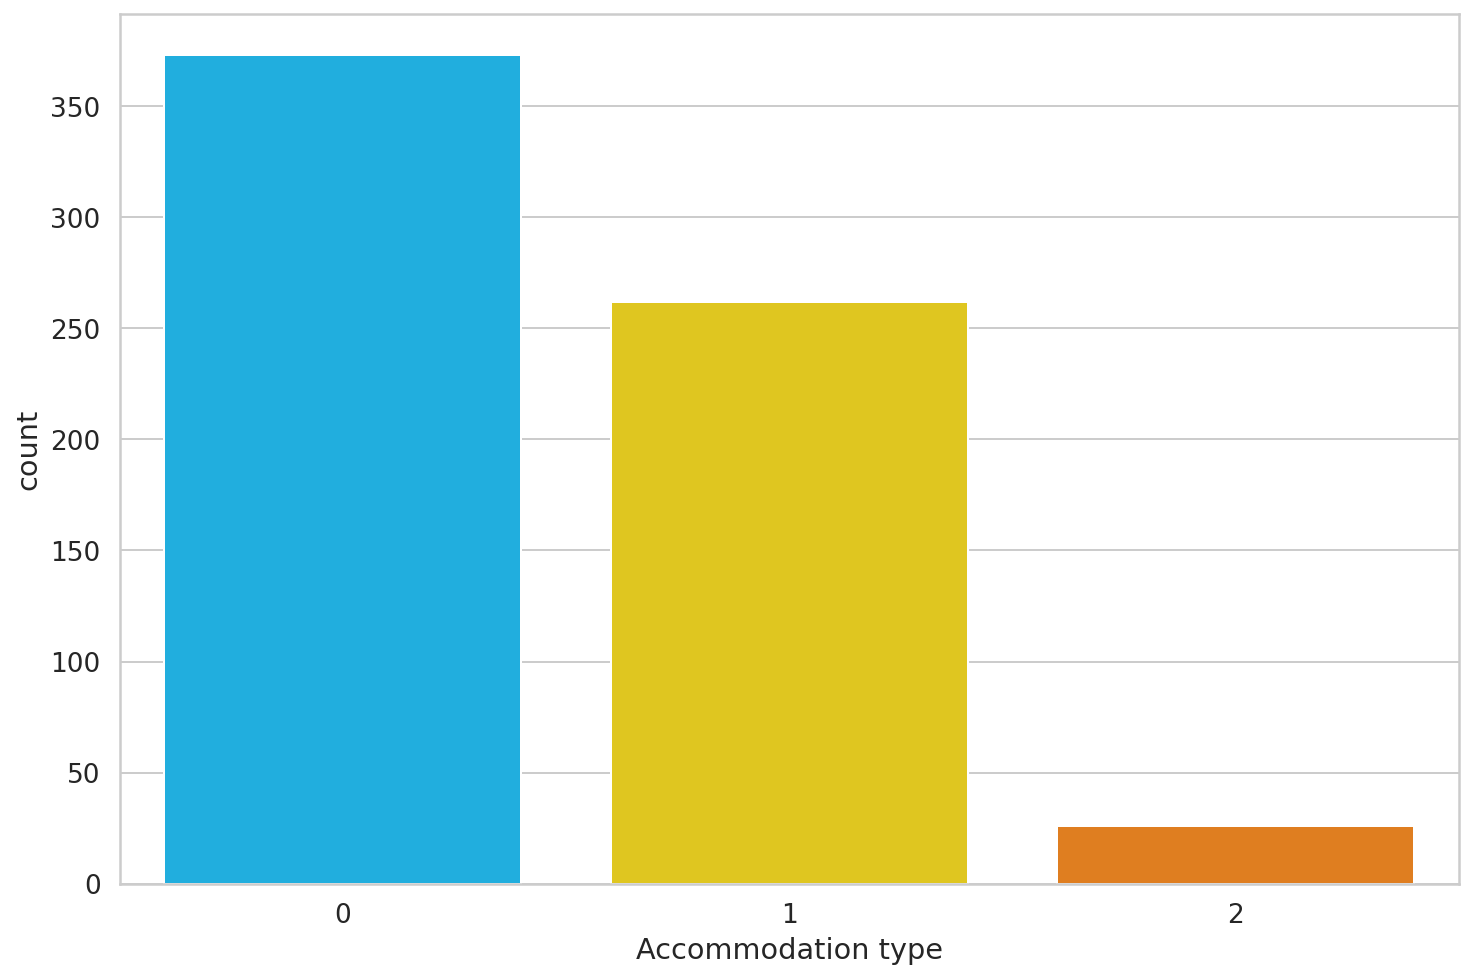

In [125]:
sns.countplot(x = 'Accommodation type', data=airbnb)

In [126]:
X = airbnb[['City', 'Guests', 'Bathrooms', 'Beds', 'Bedrooms', 'Price', 'Reviews']]
y = airbnb[['Accommodation type']]

In [171]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=6)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=2)

In [128]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)

X_test, y_test = np.array(X_test), np.array(y_test)

In [159]:
class ClassDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [160]:
targets = []
for _, t in train_dataset:
    targets.append(t)
    
targets = torch.tensor(targets)
targets = targets[torch.randperm(len(target_list))]

In [172]:
epochs = 500
batch_size = 8
lr = 0.005
num_feat = len(X.columns)
num_classes = 3

In [162]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [150]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from numpy import vstack
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch import Tensor

In [151]:
class dataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

    def get_splits(self, n_test=0.33):
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        return random_split(self, [train_size, test_size])

In [168]:

class model2(Module):
    def __init__(self, n_inputs):
        super(model2, self).__init__()

        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()

        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()

        self.hidden3 = Linear(8, 3)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax(dim=1)
    def forward(self, X):

        X = self.hidden1(X)
        X = self.act1(X)
 
        X = self.hidden2(X)
        X = self.act2(X)

        X = self.hidden3(X)
        X = self.act3(X)
        return X

In [164]:

def train_model(train_loader, model):

    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(500):

        for i, (inputs, targets) in enumerate(train_loader):

            optimizer.zero_grad()

            yhat = model(inputs)

            loss = criterion(yhat, targets.squeeze(1))

            loss.backward()

            optimizer.step()

In [165]:

def eval(test_loader, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_loader):
        yhat = model(inputs)
        yhat = yhat.detach().numpy()
        actual = targets.numpy()

        yhat = argmax(yhat, axis=1)
   
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
    
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)

    acc = accuracy_score(actuals, predictions)
    return acc

In [166]:

def predict(row, model):
    row = Tensor([row])
    yhat = model(row)

    yhat = yhat.detach().numpy()
    return yhat

In [169]:
model = model2(7)


In [157]:
train_model(train_loader, model)

In [158]:
acc = evaluate_model(test_loader, model)
print('Accuracy: %.3f' % acc)

Accuracy: 0.887


The deep neural networks gives a good accuracy for classification problem